# Curate CYP data frrom ExcapeDB (FRCE)

1. Download raw data

2. Curate - 

    2.1. dcf.get_smiles_excape_data()
    
    2.2. dcf.atom_curation()
    
    2.3. cd.average_and_remove_duplicates()
    
    2.4. cd.summarize_data()
    
3. Label 'active' column - 

    3.1. Prepare data to use in next step. Label 'relation' column based on 'Activity_Flag'
    
    3.2. cd.aggregate_assay_data() -> This labels 'active' column
    
    [ Note: I have used active_threashold=6 throughout CYP data curation from all three databases (DTC, ExcapeDB and ChEMBL) uniformly.]
    

1. Initial dataset downloaded from Excape and stored here: 

   cd /mnt/projects/ATOM/sarkart4/CYP_Data_Curation/data/
   
   mkdir excape
   
   cd excape/

    wget https://zenodo.org/record/173258#.XcXWHZJKhhE  -> This will download a file 173258. This number is the identifier of excapedb in zenodo database.
    
   
2. cd /mnt/projects/ATOM/sarkart4/CYP_Data_Curation/data/excape/

Look for Last-Modified and Length to check whether to download update DATE=date -Idate 

wget -S https://zenodo.org/record/173258/files/pubchem.chembl.dataset4publication_inchi_smiles.tsv.xz?download=1 -O excape_data.csv  -> Downloads a file named pubchem.chembl.dataset4publication_inchi_smiles.tsv.xz?download=1
https://zenodo.org/record/2543724/files/pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz?download=1
https://zenodo.org/record/2543724/files/pubchem.chembl.dataset4publication_inchi_smiles.tsv.xz?download=1
head -1 pubchem.chembl.dataset4publication_inchi_smiles.tsv > cyp3a4_excape.csv 

grep 'CYP3A4' pubchem.chembl.dataset4publication_inchi_smiles.tsv >> cyp3a4_excape.csv

---
grep CYP3A4 pubchem.chembl.dataset4publication_inchi_smiles.tsv > raw_data.txt 

head -1 pubchem.chembl.dataset4publication_inchi_smiles.tsv > header 

cat header raw_data.txt > cyp3a4_excape.csv


# ** I am starting data curation from MoDaC available files, because somehow Excape raw files are giving download error. I will fix this later - March 8, 2023

In [13]:
import importlib as imp
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper')
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [10,5]
#pal = sns.color_palette("Set2")
plt.rcParams['font.size'] = 5

In [88]:
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data

In [116]:
# Just run all cells with changing target you want
target = 'CYP3A4'

In [117]:
data_dir = "/mnt/projects/ATOM/sarkart4/MoDaC/NCI_DOE_Archive/ATOM/Safety_Screen_Targets/"+target.upper()+'-ampl-1.1.0/'
!ls $data_dir

CHEMBL25-CYP3A4_human_IC50_26Nov2019.txt
cyp3a4_chembl_testset_base_smiles_union.csv
cyp3a4_dtc_smiles_active.csv
cyp3a4_dtc_smiles.csv
cyp3a4_dtc_testset_base_smiles_union_active.csv
cyp3a4_dtc_testset_base_smiles_union.csv
cyp3a4_excape_smiles_active.csv
cyp3a4_excape_smiles_active_th5.csv
cyp3a4_excape_smiles.csv
cyp3a4_excape_testset_base_smiles_union_active.csv
cyp3a4_excape_testset_base_smiles_union.csv
cyp3a4_union_testset_base_smiles.csv
cyp3a4_union_testset_base_smiles_with_mordred_filtered_descriptors.csv
cyp3a4_union_trainset_base_smiles.csv
cyp3a4_union_trainset_base_smiles_train_valid_test_scaffold_3c072810-f47b-49ef-9365-6ffa9e5bf911.csv
cyp3a4_union_trainset_base_smiles_with_mordred_filtered_descriptors.csv
scaled_descriptors


In [118]:
file= data_dir + target.lower()+'_excape_smiles.csv' # exisitng MoDaC raw
excape_raw_df=pd.read_csv(file,sep=",",engine="python",error_bad_lines=False) # Note that my orig_df is MoDaC files, you should use the raw file downloaded form ExcapeDB
print(excape_raw_df.shape) # (14387, 13)
excape_raw_df.head()

(14387, 13)


/home/sarkart4/miniconda3/envs/ampl-1.4.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles
0,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1576,A,5.80,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21
1,AAAOTGDHZDZLFN-IHBONYPBNA-N,CHEMBL1800663,1576,A,5.25,chembl20,756121,9606,CYP3A4,un4,InChI=1/C36H32F2N6O4S/c1-42(20-18-24-9-6-7-19-...,N(C1=CC=C(C2=C(C3=C(N(C(N(C3=O)C=4C=CC=CC4)=O)...,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...
2,AABYLPRACHMDSN-CIQXGXBCNA-N,CHEMBL1593731,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@@H]2[C@](C2)([C@H](NC(OC...,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...
3,AABYLPRACHMDSN-TWWBEHSRNA-N,CHEMBL1487748,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@H]2[C@@](C2)([C@@H](NC(O...,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...
4,AADVZSXPNRLYLV-DMDYFIBKNA-N,CHEMBL1405795,1576,N,4.90,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H24N2O3/c23-17-6-5-11-10-22-8-7-13-...,O[C@@H]1[C@H]([C@@H]2[C@H](CN3[C@H](C=4NC5=C(C...,O=C(O)[C@@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...


In [119]:
excape_raw_df.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pIC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'InChI', 'SMILES', 'rdkit_smiles'],
      dtype='object')

In [120]:
print(excape_raw_df['Entrez_ID'].unique())
print(excape_raw_df['Gene_Symbol'].unique())

[1576]
['CYP3A4']


In [121]:
# Active and inactive marked by excape DB
for v in excape_raw_df['Activity_Flag'].unique() :  
    t=excape_raw_df[excape_raw_df['Activity_Flag']==v]
    print(v,t.shape)

A (8459, 13)
N (5928, 13)



### Apply standard ATOM curation steps

In [122]:
imp.reload(dcf)
data=excape_raw_df
column = 'pIC50'
tolerance = 10
list_bad_duplicates = 'Yes'
max_std = 1
compound_id = 'Original_Entry_ID'
smiles_col = 'rdkit_smiles'
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                     max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# note: checked that this is already curated
[check_df.shape]
check_df.head()
# before (14387, 17)
# after (14281, 17)
# Which means MoDaC uploaded 'raw' data have duplicates! 

Bad duplicates removed from dataset
Dataframe size (14387, 17)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [Original_Entry_ID, pIC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (14281, 17)
New column created with averaged values:  VALUE_NUM_mean


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1576,A,5.80,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,5.80,NaN,0.0,0
1,AAAOTGDHZDZLFN-IHBONYPBNA-N,CHEMBL1800663,1576,A,5.25,chembl20,756121,9606,CYP3A4,un4,InChI=1/C36H32F2N6O4S/c1-42(20-18-24-9-6-7-19-...,N(C1=CC=C(C2=C(C3=C(N(C(N(C3=O)C=4C=CC=CC4)=O)...,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...,5.25,NaN,0.0,0
2,AABYLPRACHMDSN-CIQXGXBCNA-N,CHEMBL1593731,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@@H]2[C@](C2)([C@H](NC(OC...,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...,5.60,NaN,0.0,0
3,AABYLPRACHMDSN-TWWBEHSRNA-N,CHEMBL1487748,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@H]2[C@@](C2)([C@@H](NC(O...,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...,5.60,NaN,0.0,0
4,AADVZSXPNRLYLV-DMDYFIBKNA-N,CHEMBL1405795,1576,N,4.90,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H24N2O3/c23-17-6-5-11-10-22-8-7-13-...,O[C@@H]1[C@H]([C@@H]2[C@H](CN3[C@H](C=4NC5=C(C...,O=C(O)[C@@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,4.90,NaN,0.0,0


In [123]:
check_df.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pIC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'InChI', 'SMILES', 'rdkit_smiles', 'VALUE_NUM_mean',
       'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate'],
      dtype='object')

Post-processing dataset

Total Number of results = 14281
dataset mean = 5.257695913451439 NM
dataset stdev = 0.6729923959188658 NM
dataset max = 10.66 NM
dataset min = 1.3 NM



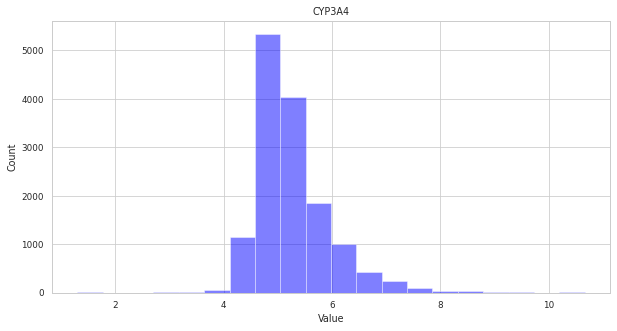

In [124]:
imp.reload(curate_data)
targ_lst = [target.upper()]
column = 'pIC50'
num_bins = 20
units = 'NM'
filepath = ""
for it in range(len(targ_lst)) :
    title = targ_lst[it]
    data=check_df
    curate_data.summarize_data(column, num_bins, title, units, filepath, data)

## Prepare for using Kevin's "aggregate_assay_data"
### Add the relation_col column by converting
### the Activity_Flag column
A -> ''

N -> '<'

In [125]:
# 'standard_relation' column created, this will be useful in next step -> aggregate_assay_data() which is the mail function to add 'active' column
agg_data=check_df
agg_data["standard_relation"] = ""
agg_data.loc[agg_data.Activity_Flag == 'N','standard_relation'] = '<'
agg_data.loc[agg_data.Activity_Flag == 'A','standard_relation'] = ''
#agg_data = agg_data.drop(['relation_col'], axis=1)
agg_data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,standard_relation
0,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1576,A,5.80,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,5.80,NaN,0.0,0,
1,AAAOTGDHZDZLFN-IHBONYPBNA-N,CHEMBL1800663,1576,A,5.25,chembl20,756121,9606,CYP3A4,un4,InChI=1/C36H32F2N6O4S/c1-42(20-18-24-9-6-7-19-...,N(C1=CC=C(C2=C(C3=C(N(C(N(C3=O)C=4C=CC=CC4)=O)...,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...,5.25,NaN,0.0,0,
2,AABYLPRACHMDSN-CIQXGXBCNA-N,CHEMBL1593731,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@@H]2[C@](C2)([C@H](NC(OC...,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...,5.60,NaN,0.0,0,
3,AABYLPRACHMDSN-TWWBEHSRNA-N,CHEMBL1487748,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@H]2[C@@](C2)([C@@H](NC(O...,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...,5.60,NaN,0.0,0,
4,AADVZSXPNRLYLV-DMDYFIBKNA-N,CHEMBL1405795,1576,N,4.90,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H24N2O3/c23-17-6-5-11-10-22-8-7-13-...,O[C@@H]1[C@H]([C@@H]2[C@H](CN3[C@H](C=4NC5=C(C...,O=C(O)[C@@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,4.90,NaN,0.0,0,<


## Use Kevin's "aggregate_assay_data" to add 'active' column

In [126]:
imp.reload(curate_data)
tolerance=10
column='pIC50'   #'pXC50'; #'standard_value'
list_bad_duplicates='Yes'
max_std=1
data=agg_data
print("before",data.shape)
temp_df=curate_data.aggregate_assay_data(data, value_col=column, output_value_col=None,
                             label_actives=True,
                             active_thresh=6, # val > 6 -> 'active' (drug-like compounds) # can be - None(default)| This creates 'active' column based on pIC50 value. Rule used here: pIC50 >=6 'active', labelled as 0, else 1
                             id_col='Ambit_InchiKey', smiles_col='rdkit_smiles', relation_col='standard_relation')
                             #id_col='standard_inchi_key', smiles_col='rdkit_smiles', relation_col='standard_relation')
# Remove inf in curated_df
temp_df = temp_df[~temp_df.isin([np.inf]).any(1)]
print("after",temp_df.shape)
temp_df.head()

before (14281, 18)
after (14278, 5)


,compound_id,base_rdkit_smiles,relation,pIC50,active
0,OUZAMIUVWNIIQH-XGVSAGGNNA-N,COC(=O)c1cc(NC(=O)/C=C/c2ccc3c(c2)OCO3)cc(C(=O...,,6.10000,1
1,SUODWKMMJQIJQB-XDJLXXALNA-N,C[C@@H](c1ccc(Cl)cc1)N1Cc2cncn2C(C[C@@H](O)c2c...,,7.00000,1
2,ZSLLGQIIRYZCIT-ZROIWOOFNA-N,Cn1c(=O)n(C)c2cc(/C=C(/C#N)c3ccc(Cl)cc3)ccc21,<,4.50000,0
3,AHHGHXFTQVZBPO-UHFFFAOYNA-N,COc1cc2ccnc(Oc3ccc(F)cc3)c2cc1OC,,5.72125,0
4,JCLYYEJMHMAUPT-UHFFFAOYNA-N,OCCN1CCN(c2nc(N3CCCCC3)nc(N3CCCCC3)n2)CC1,<,4.85000,0


In [127]:
# Add 'active' column to original data and save file to FRCE
merged = pd.merge(left=excape_raw_df, right=temp_df, how='left', left_on='rdkit_smiles', right_on='base_rdkit_smiles')
merged = merged.drop(columns=['pIC50_y', 'base_rdkit_smiles'])
merged = merged.rename(columns={'pIC50_x':'pIC50'})
print(merged.shape)
merged.head(5)

(14387, 16)


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,compound_id,relation,active
0,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1576,A,5.80,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,AAALVYBICLMAMA-MPIMZMORNA-N,,0.0
1,AAAOTGDHZDZLFN-IHBONYPBNA-N,CHEMBL1800663,1576,A,5.25,chembl20,756121,9606,CYP3A4,un4,InChI=1/C36H32F2N6O4S/c1-42(20-18-24-9-6-7-19-...,N(C1=CC=C(C2=C(C3=C(N(C(N(C3=O)C=4C=CC=CC4)=O)...,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...,AAAOTGDHZDZLFN-IHBONYPBNA-N,,0.0
2,AABYLPRACHMDSN-CIQXGXBCNA-N,CHEMBL1593731,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@@H]2[C@](C2)([C@H](NC(OC...,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...,AABYLPRACHMDSN-CIQXGXBCNA-N,,0.0
3,AABYLPRACHMDSN-TWWBEHSRNA-N,CHEMBL1487748,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@H]2[C@@](C2)([C@@H](NC(O...,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...,AABYLPRACHMDSN-TWWBEHSRNA-N,,0.0
4,AADVZSXPNRLYLV-DMDYFIBKNA-N,CHEMBL1405795,1576,N,4.90,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H24N2O3/c23-17-6-5-11-10-22-8-7-13-...,O[C@@H]1[C@H]([C@@H]2[C@H](CN3[C@H](C=4NC5=C(C...,O=C(O)[C@@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,AADVZSXPNRLYLV-DMDYFIBKNA-N,<,0.0


In [128]:
merged.active.value_counts()

0.0    12740
1.0     1544
Name: active, dtype: int64

In [129]:
merged.to_csv(data_dir +target.lower()+'_excape_smiles_active.csv')

# Add 'active' column to testset

In [130]:
excape_raw_active = pd.read_csv(data_dir + target.lower()+'_excape_smiles_active.csv' ,sep=",")
print(excape_raw_active.shape)
excape_raw_active.head(2)

(14387, 17)


,Unnamed: 0,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,compound_id,relation,active
0,0,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1576,A,5.80,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,AAALVYBICLMAMA-MPIMZMORNA-N,NaN,0.0
1,1,AAAOTGDHZDZLFN-IHBONYPBNA-N,CHEMBL1800663,1576,A,5.25,chembl20,756121,9606,CYP3A4,un4,InChI=1/C36H32F2N6O4S/c1-42(20-18-24-9-6-7-19-...,N(C1=CC=C(C2=C(C3=C(N(C(N(C3=O)C=4C=CC=CC4)=O)...,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...,AAAOTGDHZDZLFN-IHBONYPBNA-N,NaN,0.0


In [131]:
excape_test_df = pd.read_csv(data_dir + target.lower()+'_excape_testset_base_smiles_union.csv' ,sep=",")
excape_test_df.active.value_counts()

1    1312
0     837
Name: active, dtype: int64

In [132]:
excape_test_df.shape

(2149, 5)

In [133]:
excape_test_df = excape_test_df.drop(columns = ['active'])
print(excape_test_df.shape) # Note: wrong 'active' column, will be marked correctly in next step
excape_test_df.head(2)

(2149, 4)


,base_rdkit_smiles,compound_id,pIC50,relation
0,CCCC(=O)N1c2ccccc2C(N(C(C)=O)c2ccccc2)CC1C,HNPXEKAXUIALNQ-UHFFFAOYNA-N,6.05,NaN
1,CC(Cc1ccccc1)C(=O)NCCc1c[nH]c2ccccc12,GBIKZQNIVBBYRK-PKSOQXRJNA-N,5.60,NaN


In [134]:
# Add 'active' column and save file to FRCE
#merged = pd.merge(left=dtc_test_df, right=dtc_raw_active, how='left', left_on='base_rdkit_smiles', right_on='rdkit_smiles')
merged = excape_test_df.merge(excape_raw_active[['rdkit_smiles', 'active']], how = 'left', 
                           left_on = 'base_rdkit_smiles', right_on = 'rdkit_smiles').drop(columns = ['rdkit_smiles'])
print(merged.shape)
merged.head(2)

(2150, 5)


,base_rdkit_smiles,compound_id,pIC50,relation,active
0,CCCC(=O)N1c2ccccc2C(N(C(C)=O)c2ccccc2)CC1C,HNPXEKAXUIALNQ-UHFFFAOYNA-N,6.05,NaN,1.0
1,CC(Cc1ccccc1)C(=O)NCCc1c[nH]c2ccccc12,GBIKZQNIVBBYRK-PKSOQXRJNA-N,5.60,NaN,0.0


In [135]:
merged.active.value_counts()

0.0    1892
1.0     258
Name: active, dtype: int64

In [136]:
merged.to_csv(data_dir +target.lower()+'_excape_testset_base_smiles_union_active.csv')

# Plot pIC50 for A:N from Excape paper labelling (column='Activity Flag')

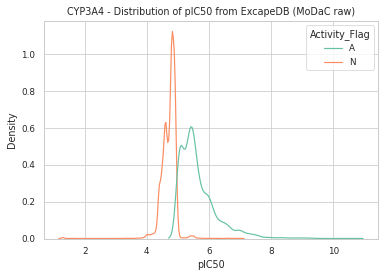

In [137]:
#plot pIC50 distribution based on ExcapeDB A:N labels (ModDaC raw)
raw = pd.read_csv(data_dir +target.lower()+'_excape_smiles_active.csv')
fig, ax = plt.subplots(figsize = (6,4))
sns.kdeplot(data=raw, x="pIC50", hue="Activity_Flag", palette="Set2")
plt.title(target.upper()+' - Distribution of pIC50 from ExcapeDB (MoDaC raw)')
plt.xlabel('pIC50')
plt.show()

# Plot pIC50 for 'Active' column from our labelling (column='active')

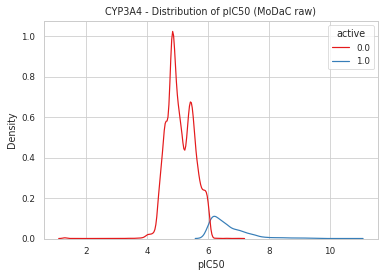

In [138]:
#plot pIC50 distribution based on our 'active' labelling (ModDaC raw)
#raw = pd.read_csv(data_dir +target.lower()+'_excape_smiles_active.csv')
fig, ax = plt.subplots(figsize = (6,4))
sns.kdeplot(data=raw, x="pIC50", hue="active", palette="Set1")
plt.title(target.upper()+' - Distribution of pIC50 (MoDaC raw)')
plt.xlabel('pIC50')
plt.show()

# Use active_threashold=5 in aggregate_assay_data()

In [139]:
imp.reload(curate_data)
tolerance=10
column='pIC50'   #'pXC50'; #'standard_value'
list_bad_duplicates='Yes'
max_std=1
data=agg_data
print("before",data.shape)
temp_df1=curate_data.aggregate_assay_data(data, value_col=column, output_value_col=None,
                             label_actives=True,
                             active_thresh=5, # val > 5 -> 'active' (drug-like compounds) # can be - None(default)| This creates 'active' column based on pIC50 value. Rule used here: pIC50 >=6 'active', labelled as 0, else 1
                             id_col='Ambit_InchiKey', smiles_col='rdkit_smiles', relation_col='standard_relation')
                             #id_col='standard_inchi_key', smiles_col='rdkit_smiles', relation_col='standard_relation')
# Remove inf in curated_df
temp_df1 = temp_df1[~temp_df1.isin([np.inf]).any(1)]
print("after",temp_df1.shape)
temp_df1.head()

before (14281, 18)
after (14278, 5)


,compound_id,base_rdkit_smiles,relation,pIC50,active
0,OUZAMIUVWNIIQH-XGVSAGGNNA-N,COC(=O)c1cc(NC(=O)/C=C/c2ccc3c(c2)OCO3)cc(C(=O...,,6.10000,1
1,SUODWKMMJQIJQB-XDJLXXALNA-N,C[C@@H](c1ccc(Cl)cc1)N1Cc2cncn2C(C[C@@H](O)c2c...,,7.00000,1
2,ZSLLGQIIRYZCIT-ZROIWOOFNA-N,Cn1c(=O)n(C)c2cc(/C=C(/C#N)c3ccc(Cl)cc3)ccc21,<,4.50000,0
3,AHHGHXFTQVZBPO-UHFFFAOYNA-N,COc1cc2ccnc(Oc3ccc(F)cc3)c2cc1OC,,5.72125,1
4,JCLYYEJMHMAUPT-UHFFFAOYNA-N,OCCN1CCN(c2nc(N3CCCCC3)nc(N3CCCCC3)n2)CC1,<,4.85000,0


In [140]:
# Add 'active' column to original data and save file to FRCE
merged = pd.merge(left=excape_raw_df, right=temp_df1, how='left', left_on='rdkit_smiles', right_on='base_rdkit_smiles')
merged = merged.drop(columns=['pIC50_y', 'base_rdkit_smiles'])
merged = merged.rename(columns={'pIC50_x':'pIC50'})
print(merged.shape)
print(merged.active.value_counts())
merged.to_csv(data_dir +target.lower()+'_excape_smiles_active_th5.csv')
merged.head(5)

(14387, 16)
1.0    7686
0.0    6598
Name: active, dtype: int64


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pIC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,compound_id,relation,active
0,AAALVYBICLMAMA-MPIMZMORNA-N,CHEMBL268868,1576,A,5.80,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H15N3O2/c24-19-15-11-17(21-13-7-3-1...,C=1C=C(NC2=C(NC3=CC=CC=C3)C=C4C(NC(C4=C2)=O)=O...,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,AAALVYBICLMAMA-MPIMZMORNA-N,,1.0
1,AAAOTGDHZDZLFN-IHBONYPBNA-N,CHEMBL1800663,1576,A,5.25,chembl20,756121,9606,CYP3A4,un4,InChI=1/C36H32F2N6O4S/c1-42(20-18-24-9-6-7-19-...,N(C1=CC=C(C2=C(C3=C(N(C(N(C3=O)C=4C=CC=CC4)=O)...,CONC(=O)Nc1ccc(-c2sc3c(c2CN(C)CCc2ccccn2)c(=O)...,AAAOTGDHZDZLFN-IHBONYPBNA-N,,1.0
2,AABYLPRACHMDSN-CIQXGXBCNA-N,CHEMBL1593731,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@@H]2[C@](C2)([C@H](NC(OC...,C[C@@H](C(=O)NCC1CC1)[C@H]1C[C@]1(C)[C@H](NC(=...,AABYLPRACHMDSN-CIQXGXBCNA-N,,1.0
3,AABYLPRACHMDSN-TWWBEHSRNA-N,CHEMBL1487748,1576,A,5.60,chembl20,737825,9606,CYP3A4,un4,InChI=1/C26H32N2O3/c1-18(24(29)27-16-19-13-14-...,O=C(NCC1CC1)[C@@H]([C@H]2[C@@](C2)([C@@H](NC(O...,C[C@@H](C(=O)NCC1CC1)[C@@H]1C[C@@]1(C)[C@@H](N...,AABYLPRACHMDSN-TWWBEHSRNA-N,,1.0
4,AADVZSXPNRLYLV-DMDYFIBKNA-N,CHEMBL1405795,1576,N,4.90,chembl20,688839,9606,CYP3A4,un4,InChI=1/C20H24N2O3/c23-17-6-5-11-10-22-8-7-13-...,O[C@@H]1[C@H]([C@@H]2[C@H](CN3[C@H](C=4NC5=C(C...,O=C(O)[C@@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,AADVZSXPNRLYLV-DMDYFIBKNA-N,<,0.0


# plot pIC50 distribution  with active_threashold=5


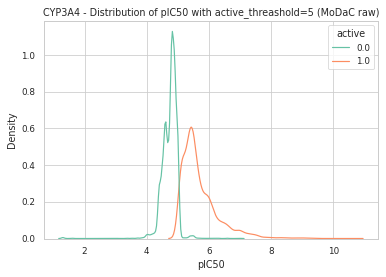

In [141]:
raw = pd.read_csv(data_dir +target.lower()+'_excape_smiles_active_th5.csv')
fig, ax = plt.subplots(figsize = (6,4))
sns.kdeplot(data=raw, x="pIC50", hue="active", palette="Set2")
plt.title(target.upper()+' - Distribution of pIC50 with active_threashold=5 (MoDaC raw)')
plt.xlabel('pIC50')
plt.show()